In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance

import pickle
import datetime
import gc
from itertools import product

In [3]:
categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv", parse_dates=True, index_col='date')
sample = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

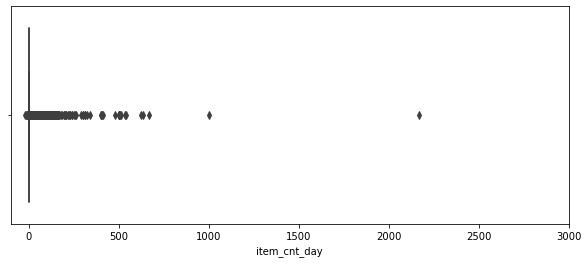

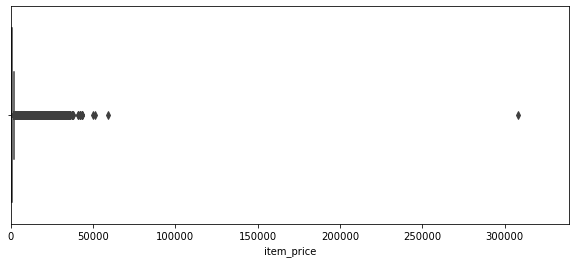

In [4]:
#finding the outliers in the train data
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[train.item_cnt_day< 1001]
train = train[train.item_price < 100000]
train = train[train.item_price >= 0]

In [6]:
#there are 363 new items in the test data which are not in train data
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [7]:
# matrix will contain all the data which we will process from the given datasets
matrix = []
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=['date_block_num', 'shop_id', 'item_id']) #vstack returns a vertically stacked ndarray
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(['date_block_num', 'shop_id', 'item_id'],inplace=True)

In [8]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
cols = ['date_block_num', 'shop_id', 'item_id']
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                               .fillna(0)
                               .clip(0,20)
                               .astype(np.float16))
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0
...,...,...,...,...
10913799,33,59,22162,0.0
10913800,33,59,22163,0.0
10913801,33,59,22164,0.0
10913802,33,59,22166,0.0


In [9]:
# appending new columns to the test data which are in train data
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

In [10]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [11]:
# month and days are also useful features for this kind of data
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [12]:
# check if there are null values in matrix and fill them with 0    
matrix['item_avg_item_price'].fillna(0, inplace=True)
matrix['date_item_avg_item_price'].fillna(0, inplace=True)
matrix.isnull().any()

date_block_num              False
shop_id                     False
item_id                     False
item_cnt_month              False
ID                          False
item_avg_item_price         False
date_item_avg_item_price    False
month                       False
days                        False
dtype: bool

In [13]:
matrix.to_pickle('data.pkl')
del matrix
del group
gc.collect();

In [14]:
data = pd.read_pickle('data.pkl')

In [15]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [16]:
del data
gc.collect()

60

In [17]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[18:00:24] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.22128	validation_1-rmse:1.13927
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.18576	validation_1-rmse:1.11452
[2]	validation_0-rmse:1.17407	validation_1-rmse:1.10637
[3]	validation_0-rmse:1.15940	validation_1-rmse:1.09661
[4]	validation_0-rmse:1.15697	validation_1-rmse:1.09359
[5]	validation_0-rmse:1.15145	validation_1-rmse:1.08950
[6]	validation_0-rmse:1.14865	validation_1-rmse:1.08816
[7]	validation_0-rmse:1.14646	validation_1-rmse:1.08757
[8]	validation_0-rmse:1.14365	validation_1-rmse:1.08522
[9]	validation_0-rmse:1.13930	validation_1-rmse:1.08576
[10]	validation_0-rmse:1.13771	validation_1-rmse:1.08478
[11]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [18]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

In [20]:
submission.to_csv('submission1.csv')